In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm import tqdm_notebook
from venn import venn
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import MinMaxScaler

In [186]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)

In [3]:
seed = 42

# load and process

In [170]:
sample_info = pd.read_excel("../../data/SamplesheetApril2020.xlsx", sheet_name='Sheet1')
sample_info = sample_info.rename(columns={'model_name': 'cell_line_name'})

In [171]:
df = pd.read_csv("../../data/drug/drug_final_processed.csv.gz", low_memory=False)

In [172]:
df_wide = pd.pivot(df, index='cell_line_name', columns='drug_id', values='ln_IC50')

In [173]:
df_wide_knn = pd.DataFrame(KNNImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)
df_wide_mean = pd.DataFrame(SimpleImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)

In [174]:
pca = PCA(n_components=3)
pca.fit(df_wide_knn)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [175]:
pca.explained_variance_ratio_

array([0.35989306, 0.05326871, 0.04842576])

In [176]:
df_pca = pd.DataFrame(
    pca.transform(df_wide_knn),
    index=df_wide_knn.index,
    columns=[f"PC{x+1}" for x in range(pca.components_.T.shape[1])])

In [177]:
df_merged = pd.merge(sample_info, df_pca.reset_index(), on=['cell_line_name'])
df_merged = pd.merge(df_merged, df_wide_knn, on=['cell_line_name'])

SpearmanrResult(correlation=0.4643504573881253, pvalue=3.959142453781478e-51)


Text(-60, 2.2, '$R=0.4644$')

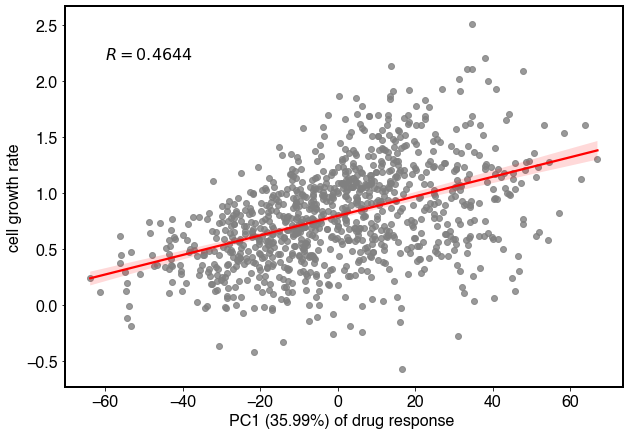

In [197]:
target = 'growth'
sns.regplot(x='PC1',
            y=target,
            data=df_merged,
            color='grey',
            line_kws={'color': 'red'})
print(
    spearmanr(df_merged.dropna()['PC1'].values,
              df_merged.dropna()[target].values))
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%}) of drug response ")
plt.ylabel("cell growth rate")
plt.text(
    -60, 2.2,
    f"$R={spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values)[0]:.4f}$"
)

SpearmanrResult(correlation=-0.8241895829567745, pvalue=2.2400690726067674e-232)
(-0.8148779945054097, 5.809548392794242e-223)


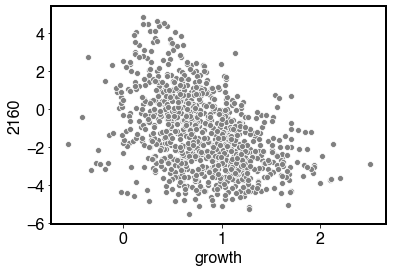

In [179]:
target = 2160
sns.scatterplot(x='growth', y=target, data=df_merged, color='grey')
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
print(pearsonr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))

In [ ]:
tmp = pd.merge(df_merged, df_wide_knn, on=['cell_line_name'])
print(spearmanr(df_merged['growth'].values, df_wide_knn[2160]))
print(pearsonr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))

# growth normalised

In [44]:
sample_info = pd.read_excel("../../data/SamplesheetApril2020.xlsx", sheet_name='Sheet1')
sample_info = sample_info.rename(columns={'model_name': 'cell_line_name'})

In [108]:
df = pd.read_csv("../../data/drug/drug_final_processed_growth_norm.csv.gz", low_memory=False)

In [109]:
df_wide = pd.pivot(df, index='cell_line_name', columns='drug_id', values='ln_IC50')

In [110]:
df_wide_knn = pd.DataFrame(KNNImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)
df_wide_mean = pd.DataFrame(SimpleImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)

In [111]:
pca = PCA(n_components=3)
pca.fit(df_wide_knn)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [112]:
pca.explained_variance_ratio_

array([0.6328997 , 0.06110007, 0.0248635 ])

In [113]:
df_pca = pd.DataFrame(
    pca.transform(df_wide_knn),
    index=df_wide_knn.index,
    columns=[f"PC{x+1}" for x in range(pca.components_.T.shape[1])])

In [114]:
df_merged = pd.merge(sample_info, df_pca.reset_index(), on=['cell_line_name'])
df_merged = pd.merge(df_merged, df_wide_knn, on=['cell_line_name'])

SpearmanrResult(correlation=-0.8793124820250464, pvalue=1.625650109957337e-302)
(-0.7904316810993706, 1.3646749201055042e-200)


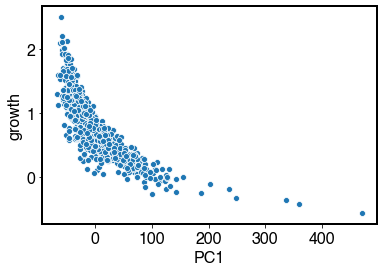

In [115]:
target = 'growth'
sns.scatterplot(x='PC1', y=target, data=df_merged)
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
print(pearsonr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))

SpearmanrResult(correlation=-0.8241895829567745, pvalue=2.2400690726067674e-232)
(-0.8148779945054143, 5.809548392732158e-223)


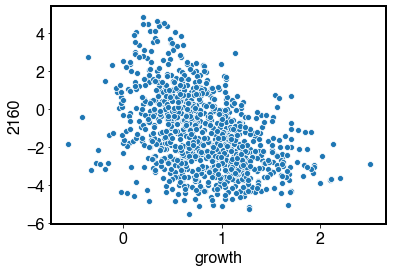

In [107]:
target = 2160
sns.scatterplot(x='growth', y=target, data=df_merged)
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
print(pearsonr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))

In [ ]:
tmp = pd.merge(df_merged, df_wide_knn, on=['cell_line_name'])
print(spearmanr(df_merged['growth'].values, df_wide_knn[2160]))
print(pearsonr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))

# growth corrected

In [140]:
sample_info = pd.read_excel("../../data/SamplesheetApril2020.xlsx", sheet_name='Sheet1')
sample_info = sample_info.rename(columns={'model_name': 'cell_line_name'})

In [141]:
df = pd.read_csv("../../data/drug/drug_final_processed_growth_corrected.csv.gz", low_memory=False)

In [142]:
df_wide = pd.pivot(df, index='cell_line_name', columns='drug_id', values='ln_IC50')

In [143]:
df_wide_knn = pd.DataFrame(KNNImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)
df_wide_mean = pd.DataFrame(SimpleImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)

In [144]:
pca = PCA(n_components=3)
pca.fit(df_wide_knn)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [145]:
pca.explained_variance_ratio_

array([0.31179993, 0.05831186, 0.0420986 ])

In [146]:
df_pca = pd.DataFrame(
    pca.transform(df_wide_knn),
    index=df_wide_knn.index,
    columns=[f"PC{x+1}" for x in range(pca.components_.T.shape[1])])

In [147]:
df_merged = pd.merge(sample_info, df_pca.reset_index(), on=['cell_line_name'])
df_merged = pd.merge(df_merged, df_wide_knn, on=['cell_line_name'])

SpearmanrResult(correlation=0.02711856655905106, pvalue=0.4077701203401217)


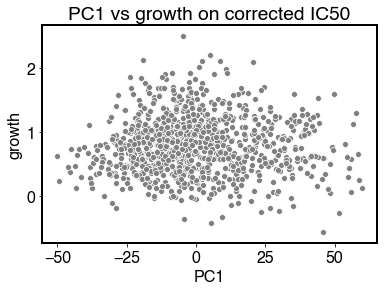

In [157]:
target = 'growth'
sns.scatterplot(x='PC1', y=target, data=df_merged, color='grey')
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
plt.title("PC1 vs growth on corrected IC50")
plt.show()

SpearmanrResult(correlation=-0.7796000113257627, pvalue=1.29352004854944e-191)


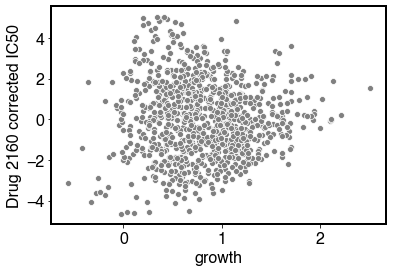

In [155]:
target = 2160
sns.scatterplot(x='growth', y=target, data=df_merged, color='grey')
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
plt.ylabel(f'Drug {target} corrected IC50')
plt.show()

# PC1 corrected

In [158]:
sample_info = pd.read_excel("../../data/SamplesheetApril2020.xlsx", sheet_name='Sheet1')
sample_info = sample_info.rename(columns={'model_name': 'cell_line_name'})

In [159]:
df = pd.read_csv("../../data/drug/drug_final_processed_pc1_corrected.csv.gz", low_memory=False)

In [160]:
df_wide = pd.pivot(df, index='cell_line_name', columns='drug_id', values='ln_IC50')

In [161]:
df_wide_knn = pd.DataFrame(KNNImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)
df_wide_mean = pd.DataFrame(SimpleImputer().fit_transform(df_wide),
                           index=df_wide.index,
                           columns=df_wide.columns)

In [162]:
pca = PCA(n_components=3)
pca.fit(df_wide_knn)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [163]:
pca.explained_variance_ratio_

array([0.08452906, 0.07686696, 0.04789837])

In [164]:
df_pca = pd.DataFrame(
    pca.transform(df_wide_knn),
    index=df_wide_knn.index,
    columns=[f"PC{x+1}" for x in range(pca.components_.T.shape[1])])

In [165]:
df_merged = pd.merge(sample_info, df_pca.reset_index(), on=['cell_line_name'])
df_merged = pd.merge(df_merged, df_wide_knn, on=['cell_line_name'])

SpearmanrResult(correlation=-0.1809597287767046, pvalue=2.5617933209372046e-08)


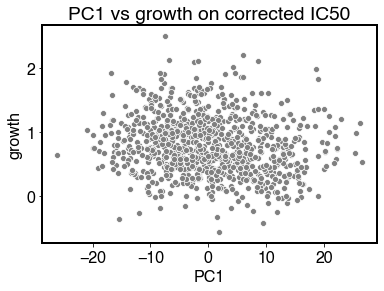

In [166]:
target = 'growth'
sns.scatterplot(x='PC1', y=target, data=df_merged, color='grey')
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
plt.title("PC1 vs growth on corrected IC50")
plt.show()

SpearmanrResult(correlation=-0.1952364048597831, pvalue=1.7800725193951338e-09)


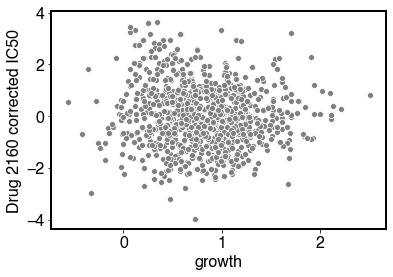

In [167]:
target = 2160
sns.scatterplot(x='growth', y=target, data=df_merged, color='grey')
print(spearmanr(df_merged.dropna()['PC1'].values, df_merged.dropna()[target].values))
plt.ylabel(f'Drug {target} corrected IC50')
plt.show()